# Introduction

This notebook builds an end‑to‑end, visual story of how a pretrained GoogLeNet (InceptionV1) processes images and what its internal features “look like.”

## Model and input

- A pretrained GoogLeNet model is loaded and set to evaluation mode so it behaves like a fixed vision model rather than a trainable network.  
- An example RGB image is loaded, resized, normalized, and converted into a tensor of shape \([1, 3, H, W]\), where 1 is the batch size and 3 are the input color channels.

## Filters, channels, and feature maps

- In the first convolutional layer, the weights have shape \([64, 3, 7, 7]\).  
  - Each \([3, 7, 7]\) block is a **filter**: a small set of learned weights that looks at a 7×7 patch across the 3 input channels.  
  - Each filter produces one **feature map** (or **output channel**) when slid over the input, so 64 filters give 64 feature maps.  
- Conceptually, each output channel corresponds to one learned **feature type** (like a particular edge orientation or color contrast), realized by many identical neurons tiled over the spatial grid.

## Capturing activations with hooks

- Forward hooks are attached to several layers: an early layer (`conv1`), a middle Inception block (`inception3a`), and a deep block (`inception5b`).  
- When an image is passed through the model, each hook saves that layer’s **activations**: tensors of shape \([1, C, H', W']\), where \(C\) is the number of channels (features) at that depth.  
- These activations are the outputs of the layers after their convolutions and nonlinearities, representing how strongly each feature fires at each spatial location.

## Visualizing feature maps

- For each hooked layer, the batch dimension is removed to get a tensor \([C, H', W']\).  
- A subset of channels is selected, and each channel’s feature map is normalized to \([0, 1]\) and plotted with a colormap (for example, `viridis`).  
- In these visualizations:
  - **Bright (high) values show where a feature is strongly active**, meaning the corresponding filter has found its preferred pattern in that region.  
  - **Dark (low) values show where it is not**, so the pattern is absent or weak there.  
- Comparing early, middle, and deep layers reveals a feature hierarchy:
  - Early maps emphasize simple edges and color contrasts.  
  - Middle maps highlight textures and object parts.  
  - Deep maps become sparse and abstract, lighting up around high‑level object regions.

In [61]:
# Import the necessary libraries for tensor operations, feature visualization and image transformation.
import torch
import torchvision.transforms.v2 as T
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import requests

# Set the device to GPU if available, otherwise CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

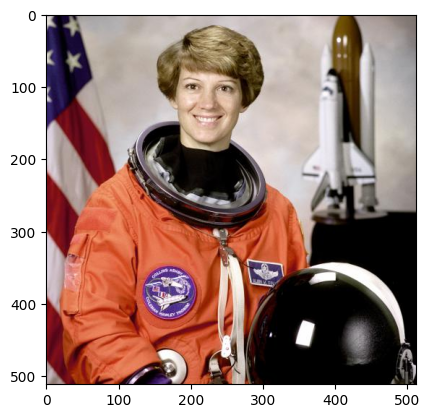

In [62]:
image_url = 'https://raw.githubusercontent.com/pytorch/vision/main/gallery/assets/astronaut.jpg'
response = requests.get(image_url, stream=True)
img = Image.open(response.raw).convert("RGB")

plt.imshow(img)
plt.axis()
plt.show()

In [63]:
# Load the pre-trained GoogLeNet model with the best available weights (currently alias for IMAGENET1K_V2) and move it to the specified device (GPU if available, else CPU).
model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT).to(device)

# Set the model to evaluation mode. This disables dropout and batch normalization updates.
model.eval()

# Standard ImageNet preprocessing for torchvision GoogLeNet
# Get the default weights which also contain the preprocessing transforms.
weights = models.GoogLeNet_Weights.DEFAULT

# Retrieve the standard preprocessing transformations (e.g., resize, center crop, tensor conversion, normalization).
preprocess = weights.transforms()

# Apply the preprocessing transformations to the input image, add a new dimension of size 1 at axis 0 of the tensor (unsqueeze(0)), and move it to the specified device.
input_tensor = preprocess(img).unsqueeze(0).to(device)

# Display the preprocessed input tensor. Its shape will be [1, 3, H, W] (batch size, channels, height, width).
input_tensor.shape

torch.Size([1, 3, 224, 224])

First conv weight shape: torch.Size([64, 3, 7, 7])


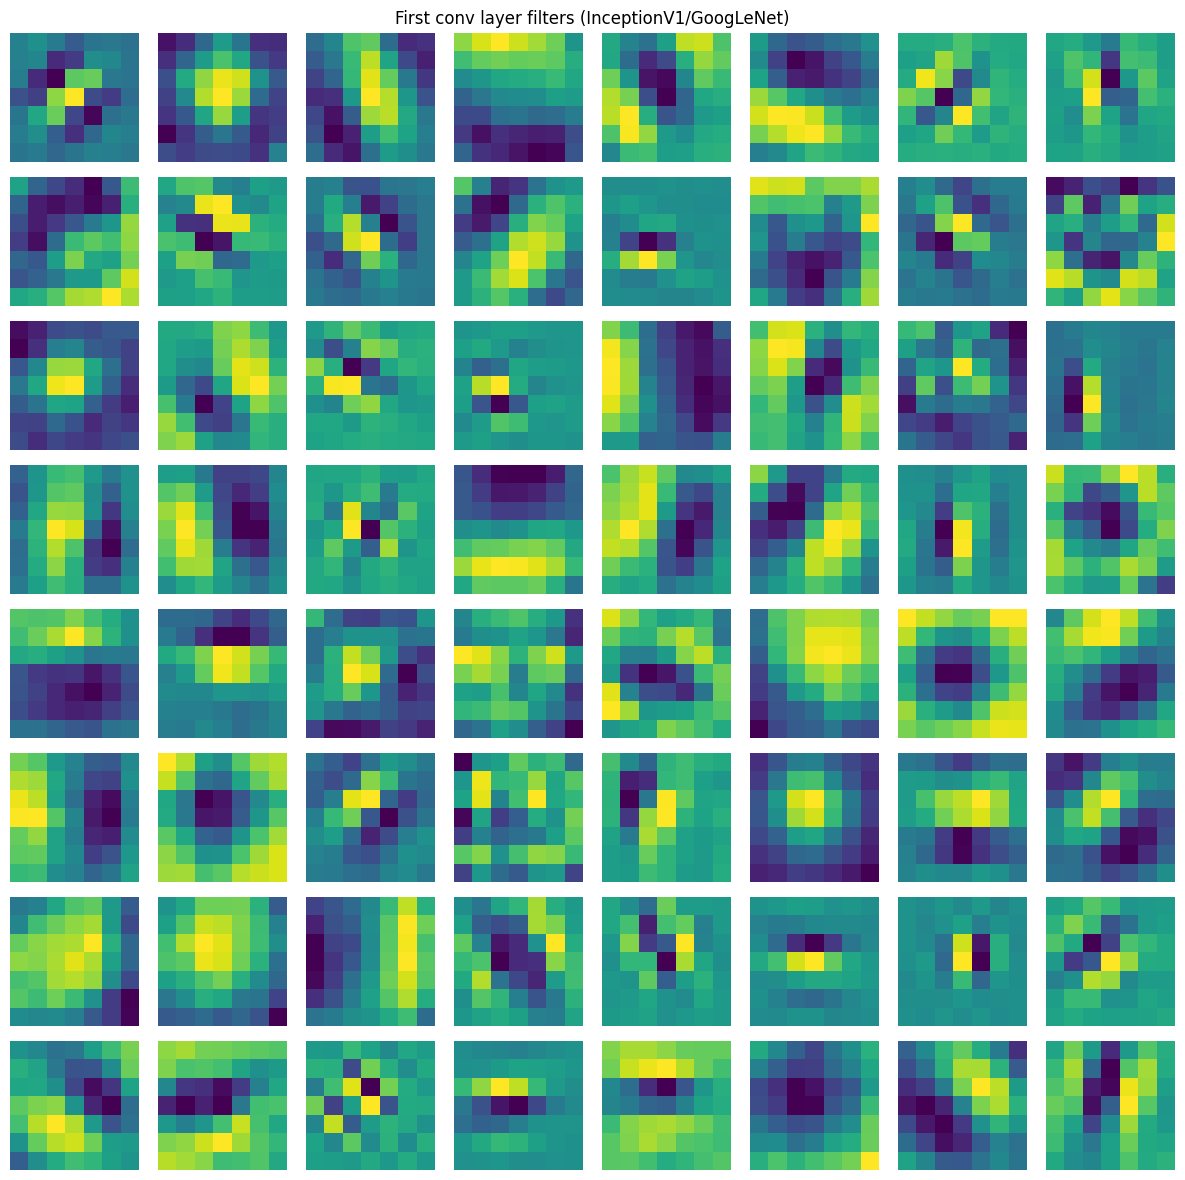

In [64]:
# Select the first convolutional layer of the model.
first_conv = model.conv1

# Get the learned filters (weights): [out_channels, in_channels, H, W]
filters = first_conv.conv.weight.data.clone().cpu()

print("First conv weight shape:", filters.shape)

# Visualize each filter (showing just the first input channel)
num_filters_to_show = min(64, filters.shape[0])

plt.figure(figsize=(12, 12))
for i in range(num_filters_to_show):
    plt.subplot(8, 8, i + 1)
    # Select the first channel (e.g., red) of the current filter for visualization.
    f = filters[i, 0, :, :]
    # Normalize the filter values to a 0-1 range for proper display.
    f = (f - f.min()) / (f.max() - f.min() + 1e-5)
    plt.imshow(f)
    plt.axis("off")

plt.suptitle("First conv layer filters (InceptionV1/GoogLeNet)")
plt.tight_layout()
plt.show()

In [65]:
# Dictionary to store activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        # detach and move to CPU so it is safe to use after the forward pass
        activations[name] = output.detach().cpu()
    return hook

# Register hook on the first, middle and deep layers
handles = []
handles.append(model.conv1.register_forward_hook(get_activation("early_conv1")))
handles.append(model.inception3a.register_forward_hook(get_activation("middle_inception3a")))
handles.append(model.inception5b.register_forward_hook(get_activation("deep_inception5b")))

In [66]:
with torch.no_grad():
    _ = model(input_tensor)  # full forward pass; hook will capture conv1 output

# Retrieve the activation
for name, act in activations.items():
    print(name, "activation shape:", act.shape)

early_conv1 activation shape: torch.Size([1, 64, 112, 112])
middle_inception3a activation shape: torch.Size([1, 256, 28, 28])
deep_inception5b activation shape: torch.Size([1, 1024, 7, 7])


In [67]:
def visualize_feature_maps(activation, title, num_maps=64):
    """
    activation: tensor of shape [1, C, H, W]
    num_maps: how many channels to visualize
    """
    act = activation.squeeze(0)  # [C, H, W]
    C = act.shape[0]
    num = min(num_maps, C)

    plt.figure(figsize=(12,12))
    for i in range(num):
        fmap = act[i]
        fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)

        plt.subplot(8, 8, i + 1)
        plt.imshow(fmap, cmap="viridis")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


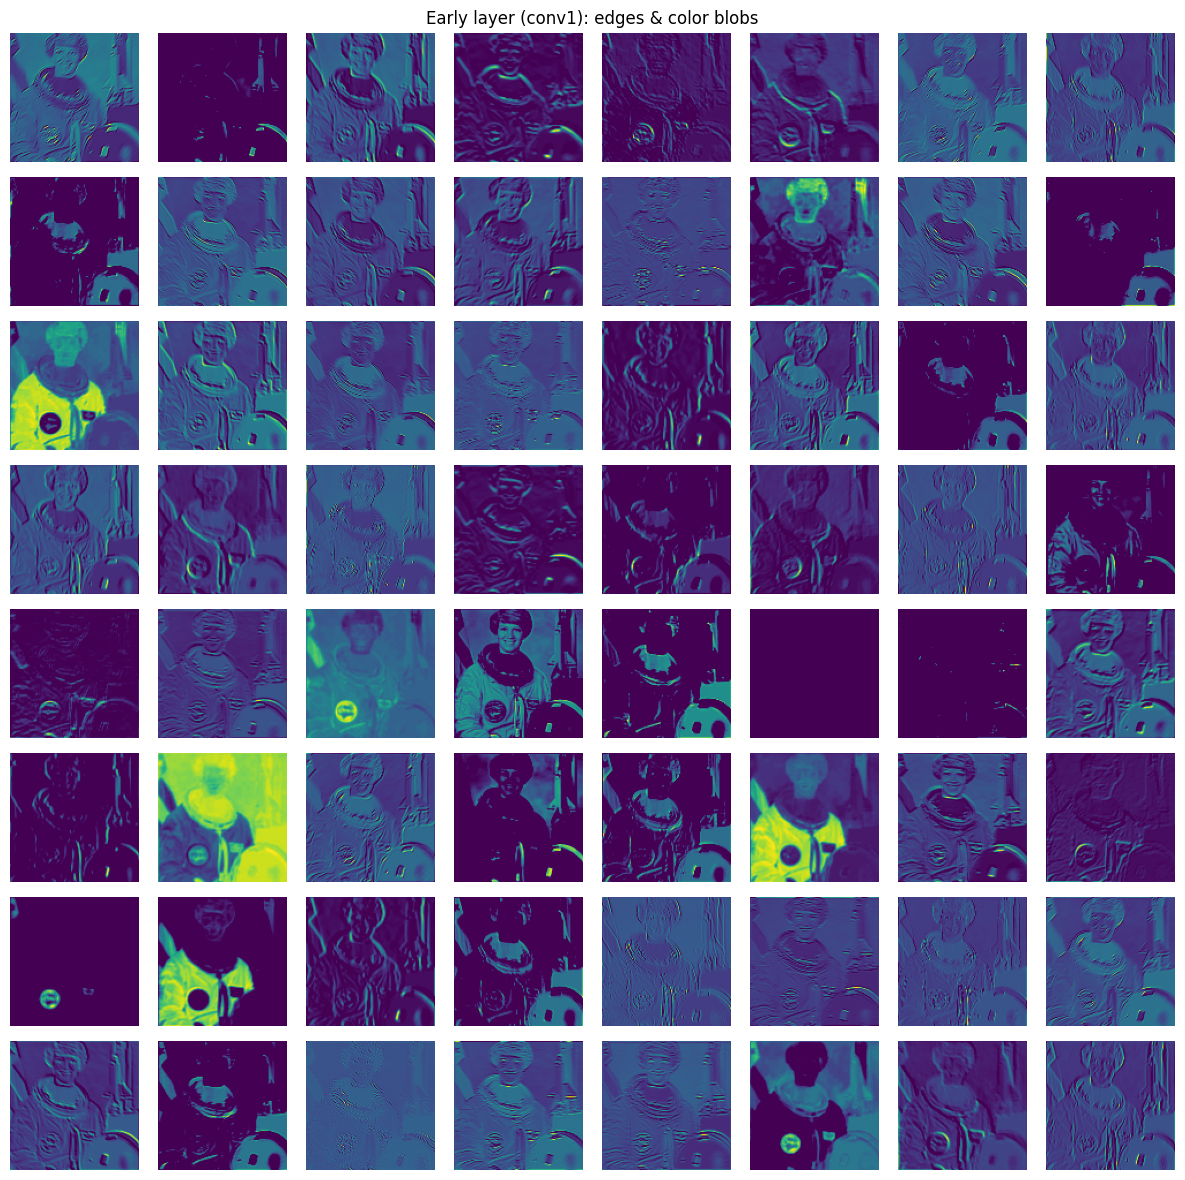

In [68]:
visualize_feature_maps(
    activations["early_conv1"],
    "Early layer (conv1): edges & color blobs",
    num_maps=64
)


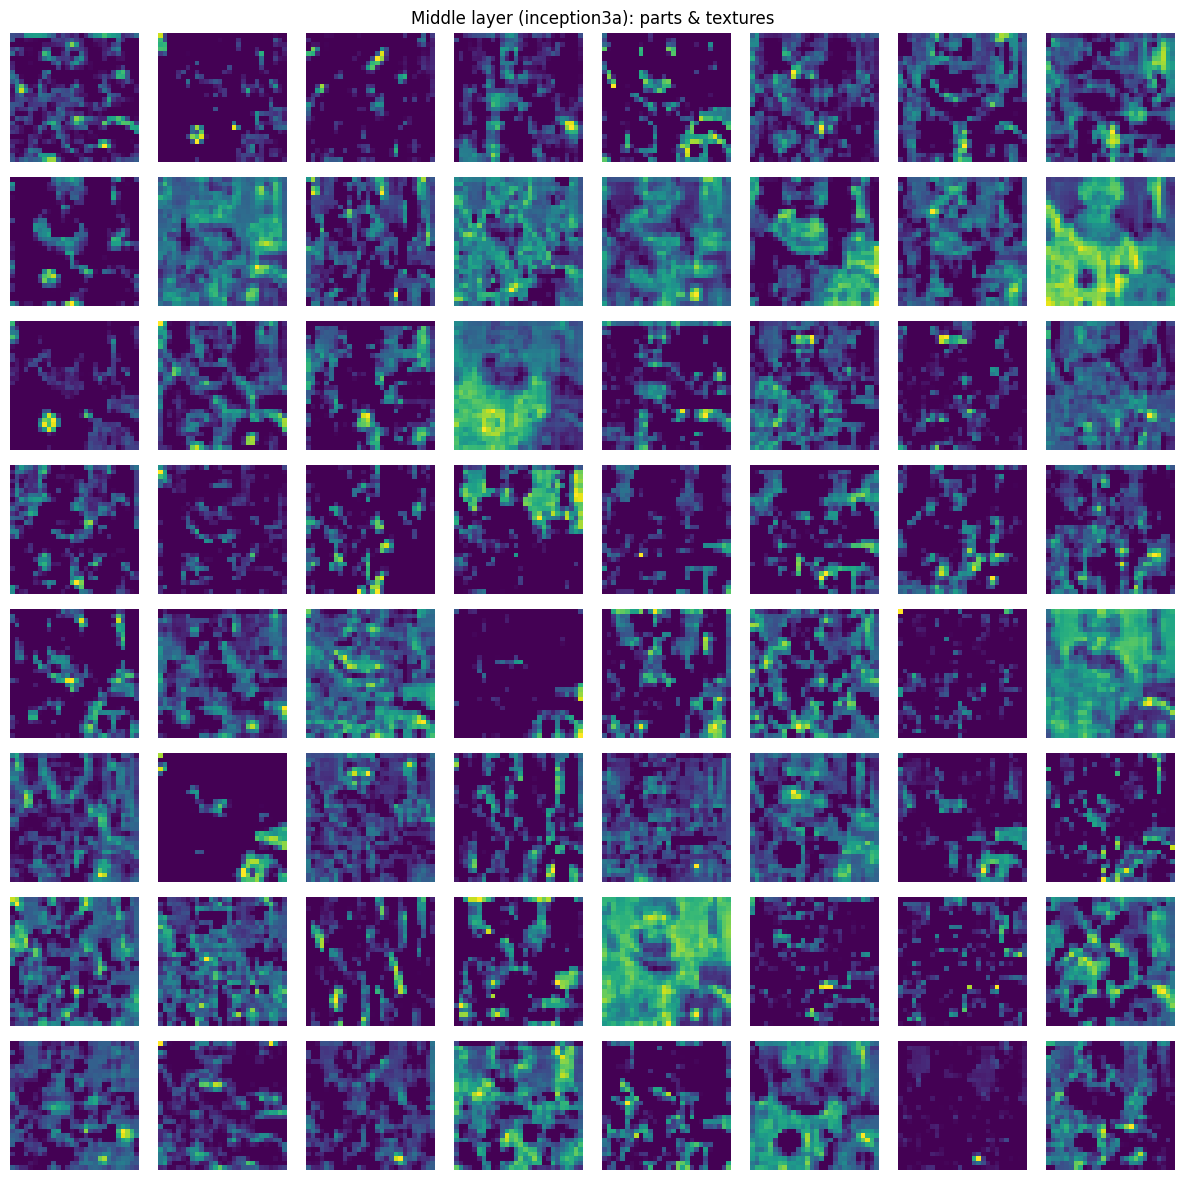

In [69]:
visualize_feature_maps(
    activations["middle_inception3a"],
    "Middle layer (inception3a): parts & textures",
    num_maps=64
)

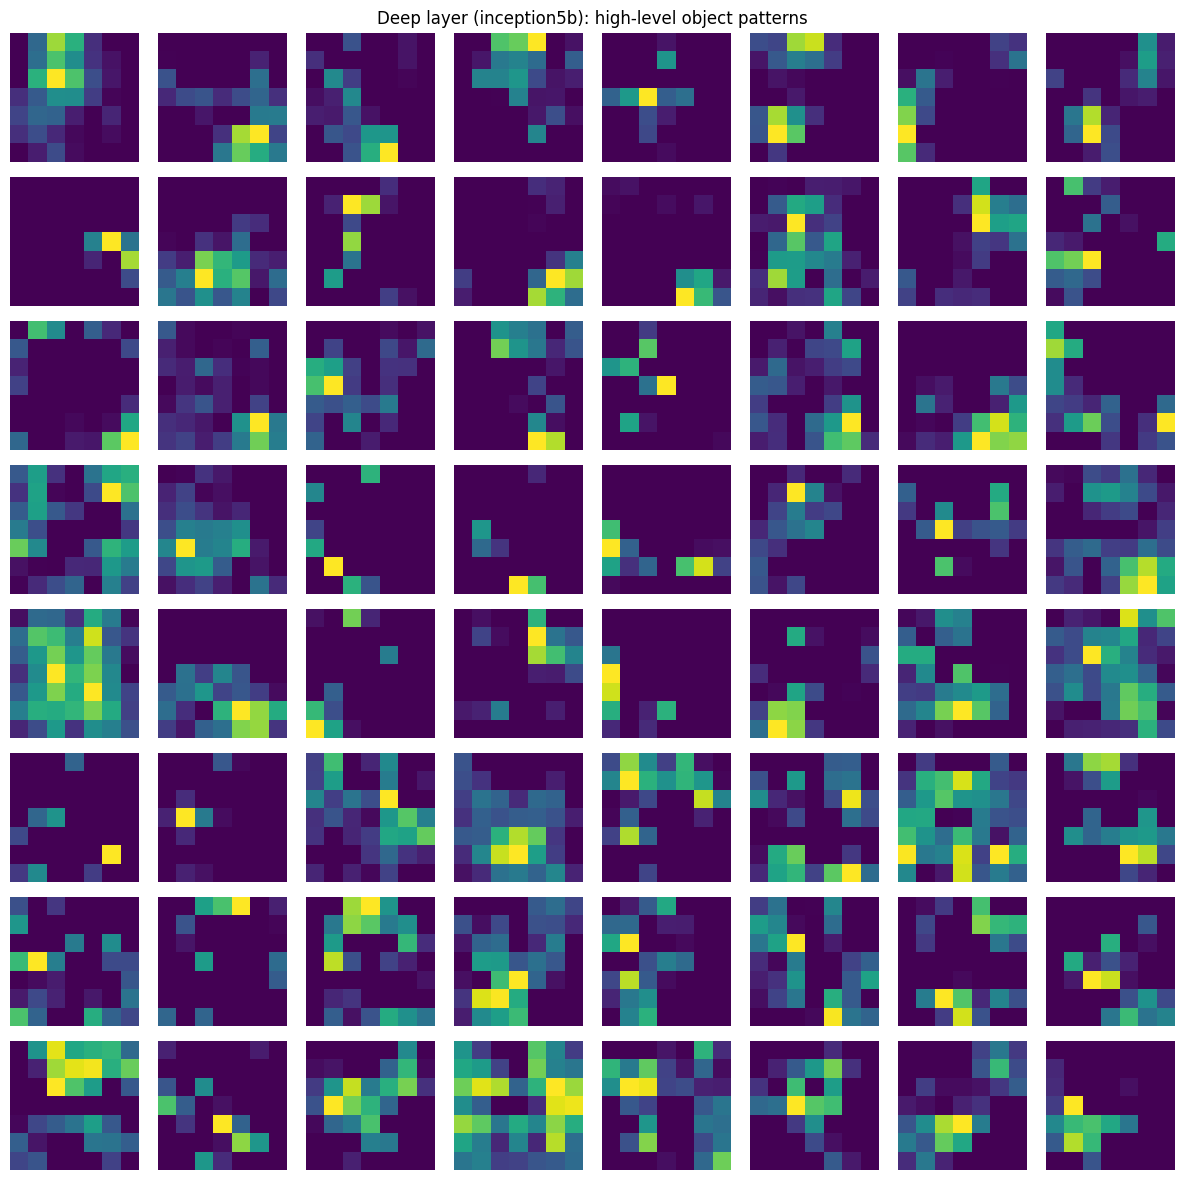

In [70]:
visualize_feature_maps(
    activations["deep_inception5b"],
    "Deep layer (inception5b): high-level object patterns",
    num_maps=64
)